# Introduction

This notebook demonstrates how to use the Vertex SDK to create video action recognition models using [AutoML](https://cloud.google.com/vertex-ai/docs/start/automl-users).

Specifically, we will be training and evaluating a model that recognizes volleyball serves.

## Dataset

We will be using a [dataset](https://docs.google.com/spreadsheets/d/1MhT_ck2PhwYhPiKBE8v0z2TaFOgSLBgO1v562qObRvc/edit#gid=0) provided by Nagra. It consists of 2 videos, each containing 10 - 100 serving events.

## Objective

In this notebook, we create an AutoML video action recognition model from a Python script, and then do a batch prediction using the Vertex SDK. 

The steps performed include:

- Create a Vertex `Dataset` resource.
- Train the model.
- View the model evaluation.
- Make a batch prediction.

Note: there is one key difference between using batch prediction and using online prediction:

* Prediction Service: Does an on-demand prediction for the entire set of instances (i.e., one or more data items) and returns the results in real-time.

* Batch Prediction Service: Does a queued (batch) prediction for the entire set of instances in the background and stores the results in a Cloud Storage bucket when ready.

## Costs

This project uses billable components of Google Cloud:

* Vertex AI [(Vertex AI
pricing)](https://cloud.google.com/vertex-ai/pricing)
* Cloud Storage [(Cloud Storage
pricing)](https://cloud.google.com/storage/pricing)


# Setup

## Development environment setup

We'll need the following components:

0. ### GCPs:

- [Google Cloud project](https://console.cloud.google.com/cloud-resource-manager).
- [GCP billing](https://cloud.google.com/billing/docs/how-to/modify-project)
- [Enablement of the following APIs: Vertex AI APIs, Compute Engine APIs, and Cloud Storage.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,storage-component.googleapis.com)


1. ### Basics:
- Git
- Python 3
- pipenv

2. ### SDKs:
- Cloud Storage SDK
- AI Platform SDK

3. ###  Data and video analytic libraries :
- pandas
- numpy
- matplotlib
- OpenCV
- [MoviePy](https://zulko.github.io/moviepy/) for video editing


Note: if we are running this notebook on Vertex AI Workbench, our environment already meets the requirements 1 and 2 above.

## Authenticate Google Cloud account (for local only)



**If we are using Vertex AI Notebooks**, your environment is already authenticated. Skip this step.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

**Click Create service account**.

In the **Service account name** field, enter a name, and click **Create**.

In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex" into the filter box, and select **Vertex Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

Click Create. A JSON file that contains your key downloads to your local environment.

Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [ ]:
# This provides access to our Cloud Storage bucket and lets us submit training jobs and prediction
# requests.
import os
import sys

# If on Google Cloud Notebook, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

# <font color='red'>Global Parameters</font>

<font color='red'> This section sets the global parameters for the downstream sections. Always run the cells in this section even if you're only running the later section (e.g. prediction)

### Project ID

In [61]:
PROJECT_ID = "sharp-leaf-344111"  # @param {type:"string"}

In [62]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)
else:
    print("Project ID:", PROJECT_ID)

Project ID: sharp-leaf-344111


In [26]:
# only run if it is local
! gcloud config set project $PROJECT_ID

Are you sure you wish to set property [core/project] to sharp-leaf-344111?

Do you want to continue (Y/n)?  ^C


Command killed by keyboard interrupt



### Region

We can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. To start with, we will be using  `europe-west4` as it is the closest to Nagra. The following regions are also available for Vertex AI:

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

Note: we may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services. (learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations))

In [63]:
REGION = "us-central1"  

### Prefix

All Vertex AI resources created will be prefixed by this preset prefix:

In [64]:
PREFIX = "volley_"

### GCS bucket

When we initialize the Vertex SDK for Python, we specify a Cloud Storage staging bucket, into which all data associated with our dataset and model resources will be saved. Set the name of our GCS below.

In [65]:
BUCKET_NAME = "gs://aliz_action_recognition_poc"  # @param {type:"string"}

**Only if the bucket doesn't already exist**: Run the following cell to create a new Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Validate access to the bucket by examining its contents:

In [7]:
! gsutil ls -al $BUCKET_NAME

 771812506  2022-03-22T07:48:19Z  gs://aliz_action_recognition_poc/RVA_16P_vs_OJVA.mp4#1647935299871660  metageneration=1
     34104  2022-03-23T18:21:05Z  gs://aliz_action_recognition_poc/sample.csv#1648059665898925  metageneration=1
       150  2022-03-23T06:00:24Z  gs://aliz_action_recognition_poc/test.jsonl#1648015224012094  metageneration=1
                                 gs://aliz_action_recognition_poc/prediction-volley_20220320155122-2022-03-22T07:52:14.495044Z/
                                 gs://aliz_action_recognition_poc/prediction-volley_20220320155122-2022-03-23T06:00:27.232831Z/
                                 gs://aliz_action_recognition_poc/videos/
TOTAL: 3 objects, 771846760 bytes (736.09 MiB)


### Vertex SDK Initialization

Initialize the Vertex SDK for Python for our project and corresponding bucket.

In [69]:
import google.cloud.aiplatform as aiplatform
aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)

# Dataset Creation


## Labels 

Now set the variable `IMPORT_FILES` to the location of the CSV index files in Cloud Storage. 

In [10]:
IMPORT_FILES = [
    "gs://aliz_action_recognition_poc/sample.csv",
]

Note: the csv file should have no header.

The columns should be as follows:
1. "test"/"train" 
2. URL of the video
3. Start time window for inspection
4. End time window for inspection
5. Name of action to be detected
6. Timestamp of the action

Let's take a quick pick at the import file specified above. 
- We count the number of examples by counting the number of rows in the CSV index file  (`wc -l`).
- We then peek at the first few rows.

In [16]:
FILE = IMPORT_FILES[0]

count = ! gsutil cat $FILE | wc -l
print("Number of Examples:", int(count[0]))

print("First 10 rows:")
! gsutil cat $FILE | head

Number of Examples: 339
First 10 rows:
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,158
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,183
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,215
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,237
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,269
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,302
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,323
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,343
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,367
test,gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4,0,2908,serve,400


## Creation of `Dataset` resource

Next, create the `Dataset` resource using the `create` method for the `VideoDataset` class, which takes the following parameters:

- `display_name`: The human readable name for the `Dataset` resource. We'll use a combination of `TRAINING_TIMESTAMP` and `PREFIX`.
- `gcs_source`: A list of one or more dataset index files to import the data items into the `Dataset` resource.

This operation may take several minutes.

In [28]:
from datetime import datetime

TRAINING_TIMESTAMP = datetime.now().strftime("%Y/%m/%d_%H:%M:%S")

In [46]:
dataset = aiplatform.VideoDataset.create(
    display_name=PREFIX + TIMESTAMP,
    gcs_source=IMPORT_FILES,
    import_schema_uri=aiplatform.schema.dataset.ioformat.video.action_recognition,
)

print(dataset.resource_name)

INFO:google.cloud.aiplatform.datasets.dataset:Creating VideoDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create VideoDataset backing LRO: projects/276875326730/locations/us-central1/datasets/7487951262084759552/operations/3500847840337330176
INFO:google.cloud.aiplatform.datasets.dataset:VideoDataset created. Resource name: projects/276875326730/locations/us-central1/datasets/7487951262084759552
INFO:google.cloud.aiplatform.datasets.dataset:To use this VideoDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.VideoDataset('projects/276875326730/locations/us-central1/datasets/7487951262084759552')
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/5306111724007456768 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.datasets.dataset:Importing VideoDataset data: projects/276875326730/locations/us-central1/datasets/7487951262084759552
INFO:google.cloud.aiplat

# Model training

To train an AutoML model, we will perform the following two steps:
1. create a training pipeline
2. run the pipeline.


## 1. Create training pipeline

An AutoML training pipeline is created with the `AutoMLVideoTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the `TrainingJob` resource.
- `prediction_type`: The type task to train the model for.
  - `classification`: A video classification model.
  - `object_tracking`: A video object tracking model.
  - `action_recognition`: A video action recognition model.

In [47]:
job = aiplatform.AutoMLVideoTrainingJob(
    display_name=PREFIX + TRAINING_TIMESTAMP,
    prediction_type="action_recognition",
)

print(job)

## 2. Run the training pipeline

Next, you run the training job by invoking the method `run`, with the following parameters:

- `dataset`: The `Dataset` resource to train the model.
- `model_display_name`: The human readable name for the trained model.
- `training_fraction_split`: The percentage of the dataset to use for training.
- `test_fraction_split`: The percentage of the dataset to use for test (holdout data).

The `run` method when completed returns the `Model` resource.

The execution of the training pipeline for this project averages to 2 h 15 m.

In [48]:
model = job.run(
    dataset=dataset,
    model_display_name=PREFIX + TRAINING_TIMESTAMP,
)

INFO:google.cloud.aiplatform.training_jobs:No dataset split provided. The service will use a default split.
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5310615323634827264?project=276875326730
INFO:google.cloud.aiplatform.training_jobs:AutoMLVideoTrainingJob projects/276875326730/locations/us-central1/trainingPipelines/5310615323634827264 current state:
PipelineState.PIPELINE_STATE_PENDING
INFO:google.cloud.aiplatform.training_jobs:AutoMLVideoTrainingJob projects/276875326730/locations/us-central1/trainingPipelines/5310615323634827264 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLVideoTrainingJob projects/276875326730/locations/us-central1/trainingPipelines/5310615323634827264 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLVideoTrainingJob projects/276875326730/locations/us-central1/trainin

KeyboardInterrupt: 

# Evaluation 

After our model has finished training, we can retrieve its evaluation metrics.

First, we'll need to get a reference to the new model. Using the name of the model (constructed using `PREFIX` and `TRAINING_TIMESTAMP`, we'll grab the name of the model.

In [70]:
# Note: adjust the correct training timestamp to choose different model versions
#-------------------------------------------------------------------------------
PREFIX = "volley_"
TRAINING_TIMESTAMP = "20220320155122"
#-------------------------------------------------------------------------------

# Get model resource ID
models = aiplatform.Model.list(filter="display_name=" + PREFIX + TRAINING_TIMESTAMP)
model = models[0]
# Get a reference to the Model Service client
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
model_service_client = aiplatform.gapic.ModelServiceClient(
    client_options=client_options
)

model_evaluations = list(model_service_client.list_model_evaluations(
    parent=models[0].resource_name
))

model_evaluation = model_evaluations[0]
print(model_evaluation)

name: "projects/276875326730/locations/us-central1/models/4028773331892174848/evaluations/5813827435929534464"
metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/video_action_recognition_metrics_1.0.0.yaml"
metrics {
  struct_value {
    fields {
      key: "evaluatedActionCount"
      value {
        number_value: 97.0
      }
    }
    fields {
      key: "videoActionMetrics"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "confidenceMetrics"
                value {
                  list_value {
                    values {
                      struct_value {
                        fields {
                          key: "confidenceThreshold"
                          value {
                            number_value: 0.99999976
                          }
                        }
                        fields {
                          key: "f1Score"
                          valu

In [71]:
# Examples as to how to get the value
model_evaluation.metrics["videoActionMetrics"][2]["precisionWindowLength"] # the "0" here refers to the different precision window length. 0 = 1s, 1 = 1s, 2 = 2s
model_evaluation.metrics["videoActionMetrics"][2]["confidenceMetrics"][0]["recall"] # choose among 'confidenceThreshold', 'recall', 'f1Score', 'precision'

0.010309278

# Prediction

In this section, we'll perform a batch prediction to using our deployed model.

### Get test item(s)

Now do a batch prediction to your Vertex model.

First, input the list of video(s) on which you'd like to evaluate your model:

In [72]:
test_videos = ["gs://aliz_action_recognition_poc/Aspire_15_vs_SG_Elite__2022-02-21.mp4"] # video's GCS URL edit here
print("The number of videos:")
print(len(test_videos))

The number of videos:
1


### Make a batch input file

Now make a batch input file, which you store in your local Cloud Storage bucket. The batch input file can be either CSV or JSONL. 

We will use JSONL. In the JSONL file, we'll make one dictionary entry per line for each video. The dictionary contains the key/value pairs:

- `content`: The Cloud Storage path to the video.
- `mimeType`: The content type. In our example, it is a `avi` file.
- `timeSegmentStart`: The start timestamp in the video to do prediction on. *Note*, the timestamp must be specified as a string and followed by s (second), m (minute) or h (hour).
- `timeSegmentEnd`: The end timestamp in the video to do prediction on.

In [73]:
import json
from google.cloud import storage

# specify start and end time segment
BUCKET_NAME = "gs://aliz_action_recognition_poc"
TIME_SEGMENT_START = "0.0"
TIME_SEGMENT_END = "1000.0" # Adjust based on the length of video(s). If different, make this a list and loop oever it


test_json_gcs_uris = []
for idx, test_video in enumerate(test_videos):   
    
    # Configure the test-data, first as a dictionary
    data_dict = {
        "content": test_video,
        "mimeType": "video/avi",
        "timeSegmentStart": f"{TIME_SEGMENT_START}s",
        "timeSegmentEnd": f"{TIME_SEGMENT_END}s",
    }
    
    json_file = f"test_{idx + 1}.json"
    data_str = json.dumps(data_dict) + "\n" 

    # Upload the json to GCS bucket
    bucket = storage.Client(project=PROJECT_ID).bucket(BUCKET_NAME.replace("gs://", ""))
    blob = bucket.blob(blob_name=json_file)
    blob.upload_from_string(data_str)

    # Check if the json is uploaded to GCS successfully
    test_json_gcs_uri = BUCKET_NAME + "/" + json_file
    print(f"{idx + 1}. The video '{test_video}' has been inputted into the test json '{test_json_gcs_uri}', whose content is as follows:")
    ! gsutil cat $test_json_gcs_uri
    
    
    test_json_gcs_uris.append(test_json_gcs_uri)

1. The video 'gs://aliz_action_recognition_poc/Aspire_15_vs_SG_Elite__2022-02-21.mp4' has been inputted into the test json 'gs://aliz_action_recognition_poc/test_1.json', whose content is as follows:


E0404 19:29:30.759550771    9430 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{"content": "gs://aliz_action_recognition_poc/Aspire_15_vs_SG_Elite__2022-02-21.mp4", "mimeType": "video/avi", "timeSegmentStart": "0.0s", "timeSegmentEnd": "1000.0s"}


### Make the batch prediction request

Now that your Model resource is trained, you can make a batch prediction by invoking the batch_predict() method, with the following parameters:

- `job_display_name`: The human readable name for the batch prediction job.
- `gcs_source`: A list of one or more batch request input files.
- `gcs_destination_prefix`: The Cloud Storage location for storing the batch prediction resuls.
- `sync`: If set to True, the call will block while waiting for the asynchronous batch job to complete.

In [74]:
from datetime import datetime

PRED_TIMESTAMP = datetime.now().strftime("%Y/%m/%d_%H:%M:%S")


for idx, test_json_gcs_uri in enumerate(test_json_gcs_uris):
    print("="*45)
    print(f"Creating prediction job for video {idx + 1}:")
    print("="*45)
    batch_predict_job = model.batch_predict(
        job_display_name=PREFIX + PRED_TIMESTAMP+ f"_{idx+1}", # each video will get one predict job
        gcs_source=test_json_gcs_uri,
        gcs_destination_prefix=BUCKET_NAME,
        sync=False,
    )
    print(batch_predict_job)

Creating prediction job for video 1:
INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.BatchPredictionJob object at 0x7fcb04cd52d0> is waiting for upstream dependencies to complete.
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/276875326730/locations/us-central1/batchPredictionJobs/1942472558175584256
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/276875326730/locations/us-central1/batchPredictionJobs/1942472558175584256')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/1942472558175584256?project=276875326730
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/1942472558175584256 current state:
JobState.JOB_STATE_PENDING
INFO:go

Next, wait for the batch job to complete. Alternatively, one can set the parameter `sync` to `True` in the `batch_predict()` method to block until the batch prediction job is completed.

### Get the predictions

Next, get the results from the completed batch prediction job.




#### From `batch_predict_job`

The results are written to the Cloud Storage output bucket you specified in the batch prediction request. 

If we still have access to the `batch_predict_job`s we created earlier (i.e. we haven't shut down this notebook yet, we can call the method `iter_outputs()` to get a list of each Cloud Storage file generated with the results. Each file contains one or more prediction requests in a JSON format:

- `content`: The prediction request.
- `prediction`: The prediction response.
 - `id`: The internal assigned unique identifiers for each prediction request.
 - `displayName`: The class name for the predicted label.
 - `timeSegmentStart`: The time offset in the video to the start of the video sequence.
 - `timeSegmentEnd`: The time offset in the video to the end of the video sequence.
 - `confidence`: The predicted confidence, between 0 and 1.

In [77]:
bp_iter_outputs = batch_predict_job.iter_outputs()

pred_results = list()
for blob in bp_iter_outputs:
    if blob.name.split("/")[-1].startswith("prediction"):
        pred_results.append(blob.name)

pred_dicts = []
for idx, pred_result in enumerate(pred_results):
    gfile_name = f"gs://{bp_iter_outputs.bucket.name}/{pred_result}".replace(
        BUCKET_NAME + "/", ""
    )
    pred_dict = bucket.get_blob(gfile_name).download_as_string()
    pred_dict = json.loads(pred_dict)
    pred_dicts.append(pred_dict)
    with open(f"pred_{idx + 1}.json", 'w') as fp:
        json.dump(pred_dict, fp)
    print(f"Prediction {idx + 1} completed.")
      

RuntimeError: Cannot read outputs until BatchPredictionJob has succeeded, current state: 3

#### From the UI

Otherwise:
- Go to the [batch predictions](https://console.cloud.google.com/vertex-ai/locations/us-central1/batch-predictions/8274472061607346176?project=sharp-leaf-344111) section of the Vertex UI
- Check your notes to see which prediction jobs correspond to which videos (you can also double check it from the input json indicated in the batch prediction job).
- Download, either via UI or gsutil, the `predictions.json` [(example)](https://console.cloud.google.com/storage/browser/aliz_action_recognition_poc/prediction-volley_20220320155122-2022-03-31T18:52:06.582487Z;tab=objects?project=sharp-leaf-344111&prefix=&forceOnObjectsSortingFiltering=false)

In [2]:
!gsutil cp gs://aliz_action_recognition_poc/prediction-volley_20220320155122-2022-03-31T18:52:06.582487Z/predictions_00001.jsonl .

Copying gs://aliz_action_recognition_poc/prediction-volley_20220320155122-2022-03-31T18:52:06.582487Z/predictions_00001.jsonl...
/ [1 files][  4.6 KiB/  4.6 KiB]                                                
Operation completed over 1 objects/4.6 KiB.                                      


# Inspection

In this section, we'll manually inspect the content of the video(s), the "real" timestamps, and the predicted timestamps.

## Downloading of necessary files from GCS

In [56]:
# copy the test videos locally so we can also inspect it
for test_video in test_videos: 
    !gsutil cp $test_video .

E0401 10:40:41.592676264   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/Aspire_11_vs_AZ_Sky_11_Gold_2022-02-05.mp4...
| [1 files][359.3 MiB/359.3 MiB]                                                
Operation completed over 1 objects/359.3 MiB.                                    


## Preprocessing

In [2]:
import numpy as np
import pandas as pd
import json

# change json file depending on the video to analyze
with open('Aspire_11_vs_AZ_Sky_11_Gold_2022-02-05.json') as json_file:
    true_label_dict = json.load(json_file)

In [3]:
true_label_df = pd.DataFrame(true_label_dict)
true_label_df

,timeText,score,type,time,detector
0,00:00:27,1,serve,27.622011,manual
1,00:00:44,1,receive,44.569000,manual
2,00:01:04,1,receive,64.520000,manual
3,00:01:24,1,receive,84.105000,manual
4,00:01:44,1,receive,104.755000,manual
5,00:02:03,1,receive,123.105011,manual
6,00:02:22,1,receive,142.055000,manual
7,00:03:27,1,receive,207.344000,manual
8,00:03:44,1,receive,224.226011,manual
9,00:04:01,1,receive,241.041000,manual


In [39]:
# Preprocessing and displaying the true label (only for original)
true_label_df = pd.read_csv("sample.csv", header = None)
true_label_df.columns = ["split", "uri", "timeStart", "timeEnd", "label", "timestamp"]
true_label_df = true_label_df[true_label_df["uri"] == "gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4"]

In [40]:
# change json file depending on the video to analyze
#with open('predictions_00001.jsonl') as json_file:
with open('prediction_0.json') as json_file:
    pred_label_data = json.load(json_file)

In [41]:
pred_label_df = pd.DataFrame.from_dict(pred_label_data["prediction"])
pred_label_df = pred_label_df.sort_values(by = "timeSegmentEnd",ascending = True)
pred_label_df = pred_label_df.reset_index(drop = True)

pred_label_df["timeSegmentEnd"] = pred_label_df["timeSegmentEnd"].str.replace(r"[a-zA-Z]",'')
pred_label_df["timeSegmentEnd"] = pred_label_df["timeSegmentEnd"].astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [43]:
true_label_df

,split,uri,timeStart,timeEnd,label,timestamp
0,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,158
1,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,183
2,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,215
3,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,237
4,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,269
...,...,...,...,...,...,...
92,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,2781
93,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,2803
94,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,2828
95,test,gs://aliz_action_recognition_poc/videos/RVA_16...,0,2908,serve,2845


In [44]:
pred_label_df

,id,displayName,timeSegmentStart,timeSegmentEnd,confidence
0,9070628431279947776,serve,0.033339s,0.033339,0.961837
1,9070628431279947776,serve,11.033339s,11.033339,0.556870
2,9070628431279947776,serve,157.033339s,157.033339,0.999988
3,9070628431279947776,serve,183.033339s,183.033339,0.995790
4,9070628431279947776,serve,205.033339s,205.033339,0.993268
5,9070628431279947776,serve,214.033339s,214.033339,0.999595
6,9070628431279947776,serve,236.033339s,236.033339,0.999990
7,9070628431279947776,serve,268.033339s,268.033339,0.999457
8,9070628431279947776,serve,302.033339s,302.033339,0.997470
9,9070628431279947776,serve,323.033339s,323.033339,0.999971


In [46]:
def combine_true_pred_label(true_label_df, 
                            pred_label_df, 
                            eps = 1, 
                            true_label_col = "timestamp", 
                            pred_label_col = "timeSegmentEnd",
                            max_time = None):
    
    true_label_df = true_label_df.copy()
    true_label_df["prediction"] = None # create a new column for prediction
    
    for row in true_label_df.iterrows():
        index = row[0]
        true_timestamp = row[1][true_label_col]
        pred_timestamps = pred_label_df[pred_label_col]
        matching_pred = pred_label_df[abs(true_timestamp - pred_timestamps) <= eps][pred_label_col]
        if len(matching_pred) == 0:
            matching_pred = None
        elif len(matching_pred) > 1:
            raise ValueError(f'More than two predictions can be matched to the true timestamp at {true_row_timestamp}, consider decreasing the eps')
        else:
            true_label_df.at[index, "prediction"] = matching_pred.values[0]
            
    true_label_df["prediction"] =  true_label_df["prediction"].astype(float)
    result_df = pd.merge(true_label_df, pred_label_df, left_on='prediction', right_on=pred_label_col, how = "outer")
    result_df = result_df[[true_label_col, pred_label_col, "confidence"]]
    result_df.columns = ["true_label", "pred", "confidence"]
    
    # sort the rows of the result_df by the average betwen true_label and pred
    def get_average(true_label, pred):
        if pd.notnull(true_label) and pd.notnull(pred):
            return (true_label + pred)/2
        elif pd.notnull(true_label):
            return true_label
        else:
            return pred
    result_df["ave"] = result_df.apply(lambda x: get_average(x["true_label"], x["pred"]), axis = 1)
    result_df = result_df.sort_values(by = ["ave"], ascending = True)
    if max_time:
        result_df = result_df[result_df["ave"] <= max_time]
    result_df = result_df.drop("ave", axis = 1)
    
    
    def put_label(real, pred):
        if pd.notnull(real) and pd.notnull(pred):
            return "true positive"
        elif pd.notnull(real):
            return"false negative"
        else:
            return "false positive"
    result_df["label"] = result_df.apply(lambda x: put_label(x['true_label'], x['pred']), axis=1)
    result_df = result_df.reset_index(drop = True)

    
    return result_df
        

In [49]:
result_df = combine_true_pred_label(true_label_df, pred_label_df, eps = 2, max_time = 1000)

In [50]:
# pretty print:
def highlight_cells(val):
    if val == "true positive":
        color = 'palegreen' 
    elif val == "false positive":
        color = "yellow"
    elif val == "false negative":
        color = "pink"
    else:
        color = ''
    
    return 'background-color: {}'.format(color)

display(result_df.style.applymap(lambda x: 'color: red' if pd.isnull(x) else '').applymap(highlight_cells))

,true_label,pred,confidence,label
0,nan,0.033339,0.961837,false positive
1,nan,11.033339,0.556870,false positive
2,nan,93.033339,0.730003,false positive
3,158.000000,157.033339,0.999988,true positive
4,183.000000,183.033339,0.995790,true positive
5,nan,205.033339,0.993268,false positive
6,215.000000,214.033339,0.999595,true positive
7,237.000000,236.033339,0.999990,true positive
8,269.000000,268.033339,0.999457,true positive
9,302.000000,302.033339,0.997470,true positive


## Manual precision/recall calculation

In [51]:
real_positive = result_df.notna().sum()["true_label"]
real_positive

33

In [52]:
pred_positive = result_df.notna().sum()["pred"]
pred_positive

37

In [53]:
true_positive = len(result_df[result_df.label == "true positive"])
true_positive

32

In [54]:
false_positive = len(result_df[result_df.label == "false positive"])
false_positive

5

In [55]:
false_negative = len(result_df[result_df.label == "false negative"])
false_negative

1

In [56]:
# Recall = True positive/Real positives
recall = true_positive/real_positive
recall

0.9696969696969697

In [57]:
# Precision = True positive/Predicted positives
precision = true_positive/pred_positive
precision

0.8648648648648649

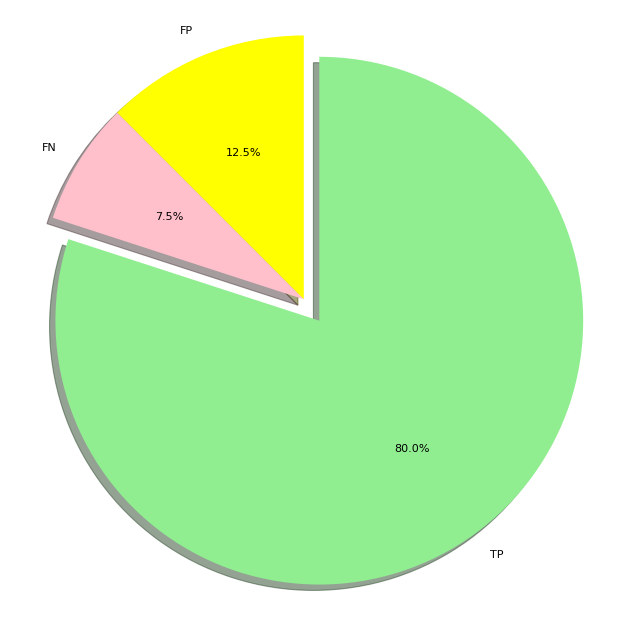

INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/1942472558175584256 current state:
JobState.JOB_STATE_RUNNING


In [79]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'FP', 'FN', 'TP'
sizes = [false_positive, false_negative+2, true_positive]
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(10, 10), dpi=80)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ["yellow","pink","lightgreen"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [41]:
comp_df.to_csv("comp_df.csv")

## Video inspection

In [76]:
# importing editor from movie py
from moviepy.editor import ColorClip, VideoFileClip, CompositeVideoClip, TextClip
  
# loading video dsa gfg intro video
clip = VideoFileClip("RVA_16P_vs_OJVA.mp4").subclip(0,5)
clip = clip.without_audio()

E0401 10:53:07.202539851   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0401 10:53:07.276007448   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0401 10:53:07.378620689   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0401 10:53:07.450068354   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [77]:
txt_clips = []
for timestamp in result_df["true_label"].tolist():
    if pd.notna(timestamp):
        txt_clip = TextClip("True serve", fontsize = 75, color = 'white')
        txt_clip = txt_clip.set_position(("left", "bottom")).set_start(timestamp).set_duration(3) 
        txt_clips.append(txt_clip)


txt_clips2 = []
for timestamp in result_df["pred"].tolist():
    if pd.notna(timestamp):
        txt_clip2 = TextClip("Pred serve", fontsize = 75, color = 'yellow')
        txt_clip2 = txt_clip2.set_position(("right", "bottom")).set_start(timestamp).set_duration(3) 
        txt_clips2.append(txt_clip2)
    
    

E0401 10:53:31.546144987   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


OSError: MoviePy Error: creation of None failed because of the following error:

convert-im6.q16: attempt to perform an operation not allowed by the security policy `@/tmp/tmp9o3p4vx3.txt' @ error/property.c/InterpretImageProperties/3666.
convert-im6.q16: no images defined `PNG32:/tmp/tmpl719lq67.png' @ error/convert.c/ConvertImageCommand/3258.
.

.This error can be due to the fact that ImageMagick is not installed on your computer, or (for Windows users) that you didn't specify the path to the ImageMagick binary in file conf.py, or that the path you specified is incorrect

In [102]:
result = CompositeVideoClip([clip] + txt_clips + txt_clips2)
#result.set_duration(200).write_videofile("test.mp4" ,audio=False, fps=2)
result.subclip(2435, 2440).write_gif("false_pos2.gif", fps=15)

/bin/bash: rpm: command not found


E0323 19:17:22.345158890   17608 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [ ]:
# ask if its professional also
# do ppl actually have multiple cameras?
# evaluate model on more videos
